<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/dev/notebooks/apple_leaf_shape_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# リンゴの葉形状解析

<img width=50% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/f34b5ffcc1d550336042f4ad800959d90736006efc850d86babfe001944ce1f9.png">
リンゴ葉データセット（公式）より。

## ライセンス
- Migicovsky, Z., Li, M., Chitwood, D. H., & Myles, S. (2017). Morphometrics Reveals Complex and Heritable Apple Leaf Shapes. Frontiers in Plant Science, 8, 2185. https://doi.org/10.3389/fpls.2017.02185
    - CC-BY
- リンゴ葉データセット（公式）
    - https://figshare.com/articles/dataset/apple_leaf/5661919
    - CC-BY
- 改変データセット
    - https://figshare.com/ndownloader/files/44279261
    - CC-BY-NC 4.0
- 本稿プログラムコード
    - CC-BY-NC 4.0

## 解説
植物の葉の形は、様々な農業的形質を理解するための指標となると考えられます。Migicovskyらは、869品種のリンゴ品種から合計9000枚の葉をスキャし、葉の形質の網羅的表現型調査を行いました。さらに得られた表現型データと品種SNP情報をあわせ、GWASやGS解析を行いました。本ノートブックでは、彼らが使用したデータセットを使い、表現型解析の多様な手法を学びます。
## 備考
公式データセットは画像サイズが大きく、ダウンロードや解析に時間がかかります。そこで、縮小・切り抜きを行い、さらには向きの正規化と、（pythonでの解析を容易とするため）白黒反転処理をしたデータセットを別途作成しました。本ノートブックでは後者を利用します。

はじめに、画像データとアノテーションcsvファイルをダウンロードします。

In [ ]:
# !wget -O apple_leaf.zip https://figshare.com/ndownloader/files/44279261
!wget -O apple_leaf.zip https://www.dropbox.com/scl/fi/slkfv6gicqpwmkk1g0mwm/apple_leaf_processed.zip?rlkey=a9h56mr9nja69uvfr43y0sitn&st=uh64kvja&dl=1
!unzip -q apple_leaf.zip
!rm apple_leaf.zip
# !wget -O leaf_genetic_image_info.zip https://figshare.com/ndownloader/files/9879460
!wget -O leaf_genetic_image_info.zip https://www.dropbox.com/scl/fi/oloue55grpb4f2pxnt06p/leaf_genetic_image_info.zip?rlkey=rryfkxhd2krrlwnyx4wp62de5&st=u6hvrm2f&dl=1
!unzip -q leaf_genetic_image_info.zip
!rm leaf_genetic_image_info.zip

楕円フーリエ解析ライブラリpyefdをインストールします。

In [ ]:
!pip -q install pyefd

In [ ]:
import os
import random
import cv2
import pyefd

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage.measure import label, regionprops

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from io import BytesIO
import matplotlib.image as mpimg

## データセット情報の読み込み
leaf_binary_image_info.txtに記述されているデータセットのメタデータを読み込みます。タブ区切りのため、delimiter="\t"を指定してデータフレームとして読み込みます。

In [ ]:
annotation_df = pd.read_csv("./leaf_genetic_image_info/leaf_binary_image_info.txt", delimiter="\t")
annotation_df

,image_name,nursery_id,apple_id
0,10004-2-3762,10004,915
1,10004-2-3763,10004,915
2,10004-2-3764,10004,915
3,10004-2-3765,10004,915
4,10004-2-3766,10004,915
...,...,...,...
8990,9324-2-2516,9324,914
8991,9324-2-2517,9324,914
8992,9324-2519,9324,914
8993,9324-2520,9324,914


nursery_idは個体（樹木）ごとに割り振られた固有ID、apple_idが品種ごとに割り振られた固有IDです。
どのような画像か、確認してみましょう。

In [ ]:
IMAGE_DIR = "./apple_leaf_processed"
files = sorted(os.listdir(IMAGE_DIR))

# or can obtain names through annotation file
# files = annotation_df["image_name"] + ".jpg"
# files = files.values.tolist()

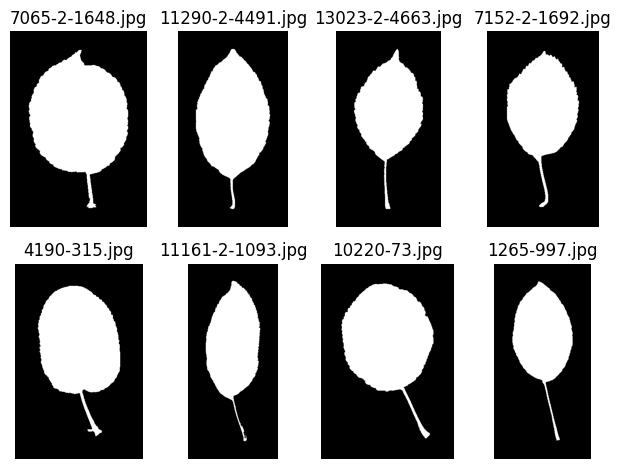

In [ ]:
for i, file in enumerate(random.sample(files, 8)):
    path = os.path.join(IMAGE_DIR, file)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.subplot(2,4,i+1)
    plt.title(file)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
plt.tight_layout()

## 解析

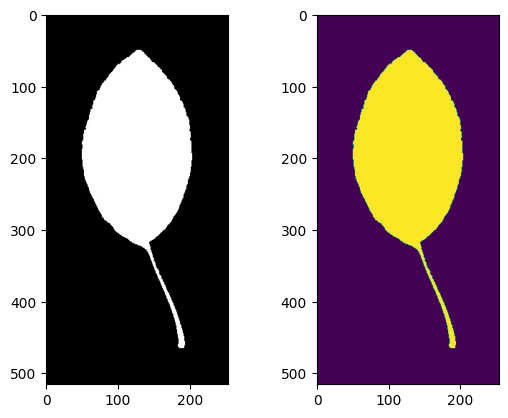

In [ ]:
file = files[-1]
path = os.path.join(IMAGE_DIR, file)
image = cv2.imread(path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary = gray > 100
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(binary)

面積を求めましょう。boolean arrayに対してnp.sumを適用することでTrueの数＝面積を求めることができます。

In [ ]:
phenotype = {}

In [ ]:
phenotype["area"] = np.sum(binary)
print(phenotype["area"])

31026


葉の形を定量するために、葉の端点（上端、下端、左端、右端）の座標がわかれば幅や長さがわかりそうです。
マスク画像の葉領域の端点は、例えば以下のようにして求めることができます。

In [ ]:
def find_extreme_points(mask):
    # returns coordinates in x,y format
    true_points = np.argwhere(mask)

    if true_points.size == 0:
        return None  # No True values in the mask

    top_most = true_points[np.argmin(true_points[:, 0])][::-1]
    bottom_most = true_points[np.argmax(true_points[:, 0])][::-1]
    left_most = true_points[np.argmin(true_points[:, 1])][::-1]
    right_most = true_points[np.argmax(true_points[:, 1])][::-1]

    return (top_most,
            bottom_most,
            left_most,
            right_most)

phenotype["leaf_extreme_coords"] = {}
extreme_coords = find_extreme_points(binary)
phenotype["leaf_extreme_coords"]["top_most"] = extreme_coords[0]
phenotype["leaf_extreme_coords"]["bottom_most"] = extreme_coords[1]
phenotype["leaf_extreme_coords"]["left_most"] = extreme_coords[2]
phenotype["leaf_extreme_coords"]["right_most"] = extreme_coords[3]

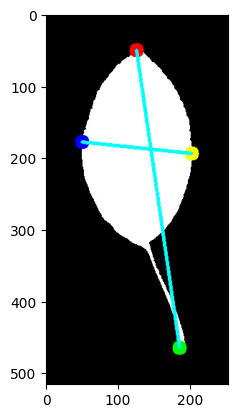

In [ ]:
annotated = image.copy()
# colors in order or R,G,B,Y
colors = [
    (255,0,0),(0,255,0),
     (0,0,255),(255,255,0)
]

for i, (key, value) in enumerate(phenotype["leaf_extreme_coords"].items()):
    cv2.circle(annotated, value, 10, colors[i], -1)

_ = cv2.line(annotated,
         phenotype["leaf_extreme_coords"]["top_most"],
         phenotype["leaf_extreme_coords"]["bottom_most"],
         color=(0, 255, 255),
         thickness=3,
         )

_ = cv2.line(annotated,
         phenotype["leaf_extreme_coords"]["left_most"],
         phenotype["leaf_extreme_coords"]["right_most"],
         color=(0, 255, 255),
         thickness=3,
         )

plt.imshow(annotated)
plt.show()

In [ ]:
# calculate the distance between two points
v_length = np.linalg.norm(
    phenotype["leaf_extreme_coords"]["top_most"] - phenotype["leaf_extreme_coords"]["bottom_most"])

h_length = np.linalg.norm(
    phenotype["leaf_extreme_coords"]["right_most"] - phenotype["leaf_extreme_coords"]["left_most"])

phenotype["v_length"] = v_length
phenotype["h_length"] = h_length
print("verrtical length", phenotype["v_length"])
print("horizontal length", phenotype["h_length"])


verrtical length 419.3149174546501
horizontal length 153.83432646844463


## 葉身の単離
ところで、上述の表現型抽出方法では葉柄が含まれています。葉身の形を定量したい場合、邪魔になるため、除去してみましょう。
ここではcv2.erodeとcv2.dilateを利用します。cv2.erodeで領域の縮小、cv2.dilateで領域の拡大ができます。下の結果を見てみましょう。

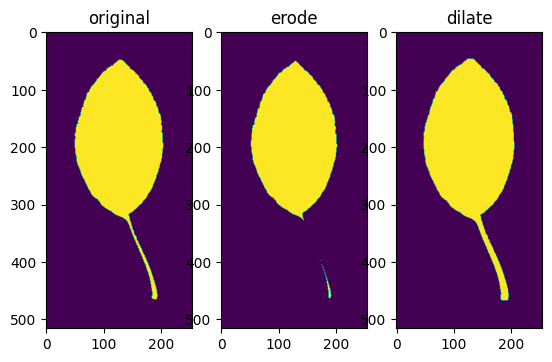

In [ ]:
kernel = np.ones((5,5),np.uint8)

_binary = binary.copy().astype(np.uint8)
eroded = cv2.erode(_binary, kernel=kernel)
_binary = binary.copy().astype(np.uint8)
dilated = cv2.dilate(_binary, kernel=kernel)

plt.subplot(1,3,1)
plt.title("original")
plt.imshow(binary)

plt.subplot(1,3,2)
plt.title("erode")
plt.imshow(eroded)
plt.subplot(1,3,3)
plt.title("dilate")
plt.imshow(dilated)

plt.show()

一定回数erodeをし、追って同じ回数dilateを適用すれば、マスク画像を（おおむね）もとの形に戻せるのと同時に、細い葉身の領域が除去できると期待されます（＝erodeによって葉柄が完全に消えると、dilateでも元に戻らない）。
cv2.erodeとcv2.dilateはそれぞれiterations引数で処理の繰り返し回数が指定できますので、iterationsの条件を振って結果を比べてみましょう。

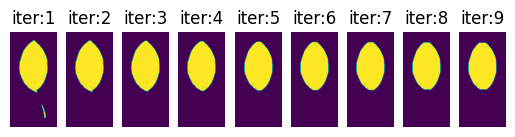

In [ ]:
kernel = np.ones((5,5),np.uint8)

for i in range(9):
    plt.subplot(1,9,i+1)
    _binary = binary.copy().astype(np.uint8)
    _binary = cv2.erode(_binary, kernel=kernel, iterations=i+1)
    _binary = cv2.dilate(_binary, kernel=kernel, iterations=i+1)
    plt.imshow(_binary)
    plt.title(f"iter:{i+1}")
    plt.axis("off")


今回の画像の場合、iterations=２で葉柄が消失しました。4をここでは採用しましょう。


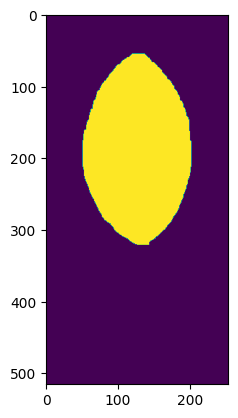

In [ ]:
lb_binary = binary.copy().astype(np.uint8)
lb_binary = cv2.erode(lb_binary, kernel=kernel, iterations=4)
lb_binary = cv2.dilate(lb_binary, kernel=kernel, iterations=4)
plt.imshow(lb_binary)

得られたmask画像の下端を求めれば、葉身の”つけね”の（おおよその）座標を得ることができます。

In [ ]:
# do not use else than bottom extreme points
_, lb_bottom_most, _, _ = find_extreme_points(lb_binary)
phenotype["leaf_extreme_coords"]["lb_bottom_most"] = lb_bottom_most

lb_v_length = np.linalg.norm(
    phenotype["leaf_extreme_coords"]["lb_bottom_most"] - phenotype["leaf_extreme_coords"]["top_most"])
phenotype["lb_v_length"] = lb_v_length
print(phenotype["lb_v_length"])

_ = cv2.circle(annotated,
           phenotype["leaf_extreme_coords"]["lb_bottom_most"],
           10, (0,255,0), -1)

_ = cv2.line(annotated,
         phenotype["leaf_extreme_coords"]["top_most"],
         phenotype["leaf_extreme_coords"]["lb_bottom_most"],
         color=(0, 255, 255),
         thickness=3,
         )

271.0018450121696


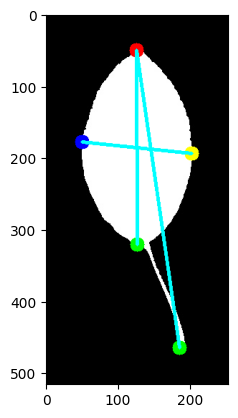

In [ ]:
plt.imshow(annotated)
plt.show()

ここまでで得られた表現型を出力してみましょう。

In [ ]:
for k,v in phenotype.items():
    print(k, v)

area 31026
leaf_extreme_coords {'top_most': array([126,  50]), 'bottom_most': array([186, 465]), 'left_most': array([ 50, 178]), 'right_most': array([203, 194]), 'lb_bottom_most': array([127, 321])}
v_length 419.3149174546501
h_length 153.83432646844463
lb_v_length 271.0018450121696


ところで、このような形状解析では、scikit-imageのlabelとregionpropsを利用することで、手動計算では大変な形状パラメーターを容易に得ることができます。詳細はhttps://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops　を参照してください。


In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary = gray > 100
lbl_image = label(binary)
props = regionprops(lbl_image)
idx = np.argmax([x.area for x in props])
prop = props[idx]

In [ ]:
print("面積", prop.area)
print("重心", prop.centroid)
print("凸包面積", prop.area_convex)
print("長軸長", prop.axis_major_length)
print("長軸長", prop.axis_minor_length)
print("楕円度", prop.eccentricity)
print("ソリディティ", prop.solidity)

面積 31026
重心 (195.0240443499001, 128.5958228582479)
凸包面積 40604
長軸長 292.5490947680656
長軸長 149.12103063927677
楕円度 0.8603344668398016
ソリディティ 0.7641119101566348


## 楕円フーリエ記述子による輪郭解析
これまでに紹介したように、葉の表現型に関する尺度（メトリクス）を手動設計することで、品種の特性を明らかとし、比較することが可能になります。しかしながら、例えば「どれだけ先端が尖っているか」「鋸歯があるか」などという尺度を用いたい場合、設計が大変になります。そのようなとき、葉の輪郭を周期関数として捉え、楕円フーリエ変換を通して再構成（近似）することができます。変換の仮定で得られる楕円フーリエ係数そのものを表現型そのものとして扱うことで品種間比較が可能になります。

楕円フーリエ解析は、cv2.findContoursで得られた輪郭座標をpyefdというライブラリで処理することで簡単におこなうことができます。

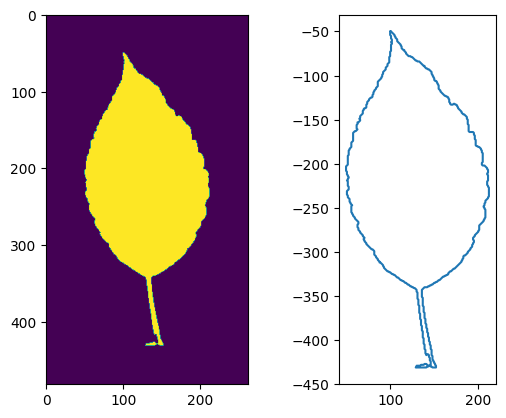

In [ ]:
file = files[0]
path = os.path.join(IMAGE_DIR, file)
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = image > 100
image = image.astype(np.uint8)
contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.gca().set_aspect('equal')
plt.plot(np.squeeze(contour)[:,0],-np.squeeze(contour)[:,1])

In [ ]:
EFD_HARMONICS = 15

coeffs = pyefd.elliptic_fourier_descriptors(np.squeeze(contour), order=EFD_HARMONICS)
normalized_coeffs = pyefd.normalize_efd(coeffs)


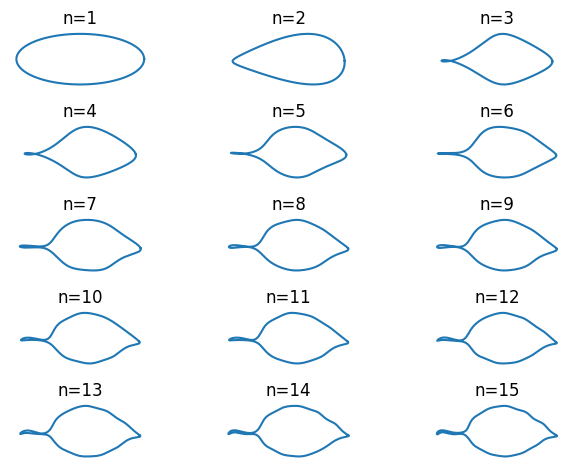

In [ ]:
for i, harmonics in enumerate(range(EFD_HARMONICS)):
    c = pyefd.reconstruct_contour(coeffs[:i+1], locus=(0, 0), num_points=300)
    plt.subplot(5,3,i+1)
    plt.gca().set_aspect('equal')
    plt.title(f"n={str(i+1)}")
    plt.plot(c[:,0], c[:,1])
    plt.axis("off")
plt.tight_layout()

In [ ]:
efd_df = annotation_df.drop("nursery_id",axis=1)
efd_df["apple_id"] = efd_df["apple_id"].astype(str)
for i in range(EFD_HARMONICS*4):
    efd_df[f"coeff_{str(i).zfill(2)}"] = np.nan
efd_df.head()

,image_name,apple_id,coeff_00,coeff_01,coeff_02,coeff_03,coeff_04,coeff_05,coeff_06,coeff_07,...,coeff_50,coeff_51,coeff_52,coeff_53,coeff_54,coeff_55,coeff_56,coeff_57,coeff_58,coeff_59
0,10004-2-3762,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10004-2-3763,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10004-2-3764,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10004-2-3765,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10004-2-3766,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for i, row in tqdm(efd_df.iterrows(), total=len(efd_df)):
    file = row["image_name"] + ".jpg"
    path = os.path.join(IMAGE_DIR, file)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image > 100
    image = image.astype(np.uint8)
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 1:
        lengths = [len(x) for x in contours]
        idx = np.argmax(lengths)
        contour = contours[idx]
    else:
        contour = contours[0]

    coeffs = pyefd.elliptic_fourier_descriptors(np.squeeze(contour), order=EFD_HARMONICS)
    normalized_coeffs = pyefd.normalize_efd(coeffs)
    feature = normalized_coeffs.flatten()

    for n in range(EFD_HARMONICS*4):
        efd_df.at[i, f"coeff_{str(n).zfill(2)}"] = feature[n]


  0%|          | 0/8995 [00:00<?, ?it/s]

In [ ]:
efd_df

,image_name,apple_id,coeff_00,coeff_01,coeff_02,coeff_03,coeff_04,coeff_05,coeff_06,coeff_07,...,coeff_50,coeff_51,coeff_52,coeff_53,coeff_54,coeff_55,coeff_56,coeff_57,coeff_58,coeff_59
0,10004-2-3762,915,1.0,5.763381e-17,1.004495e-16,-0.396016,0.011531,0.019933,-0.018261,-0.120641,...,0.001789,-0.001541,0.001776,0.003183,-0.002081,0.005629,0.000903,0.004969,0.002045,-0.003606
1,10004-2-3763,915,1.0,-4.046694e-17,-8.948594e-17,-0.402990,0.009960,-0.007470,0.053000,-0.108769,...,-0.002827,-0.001297,-0.000725,-0.002520,0.002315,0.002789,0.004403,-0.001836,-0.001263,-0.003084
2,10004-2-3764,915,1.0,-2.364566e-17,-9.117675e-17,-0.367554,0.021347,-0.005887,0.040347,-0.137522,...,0.000457,-0.007502,0.004353,0.000312,0.000583,0.007419,-0.002405,-0.004424,0.000079,-0.003104
3,10004-2-3765,915,1.0,3.008360e-17,6.498555e-17,-0.412021,-0.003750,0.009746,-0.006346,-0.127073,...,0.000843,0.001461,-0.000462,-0.000213,-0.000341,0.001482,0.006259,-0.000149,0.002416,-0.003196
4,10004-2-3766,915,1.0,2.715026e-18,1.017784e-18,-0.389525,0.003885,0.003970,-0.005386,-0.088518,...,-0.001295,0.001371,0.000682,0.002694,-0.000700,0.000386,0.005797,-0.000784,-0.000867,-0.002172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8990,9324-2-2516,914,1.0,1.653760e-17,2.833431e-17,-0.321054,-0.011358,-0.022107,-0.032235,-0.187493,...,0.001505,-0.000003,-0.001971,-0.002464,0.001264,0.001879,0.005145,-0.000999,0.002050,-0.000842
8991,9324-2-2517,914,1.0,-2.853578e-17,-1.058573e-16,-0.262481,-0.022168,-0.004937,0.037927,-0.192338,...,-0.001190,0.002539,-0.002377,-0.000058,-0.000585,0.001279,0.004389,-0.001890,-0.002790,-0.002401
8992,9324-2519,914,1.0,1.168031e-17,1.507019e-17,-0.338238,0.003585,0.021227,0.019014,-0.187462,...,-0.002670,-0.003309,-0.000709,-0.000112,0.002217,0.000097,0.002657,-0.001902,0.001887,-0.000922
8993,9324-2520,914,1.0,1.667617e-17,2.816333e-17,-0.316208,-0.004361,0.011174,-0.000677,-0.180689,...,-0.000120,-0.001255,-0.000657,0.001962,-0.000709,0.001504,0.003743,0.001201,0.000141,0.000701


標準化された楕円フーリエ計数は第１から第３計数がほぼ1,0,0の値をとるため、解析から除外してからPCAを行います。
ここでは品種ごとに平均化した値を算出し、品種の平均形状として解析することとします。

In [ ]:
group_df = efd_df.drop(["image_name","coeff_00","coeff_01","coeff_02"], axis=1).groupby("apple_id").mean()

pca = PCA()
principalComponents = pca.fit_transform(group_df)
pca_df = pd.DataFrame(data = principalComponents, columns = [f'PC{x+1}' for x in range(len(pca.explained_variance_))])
pca_df['apple_id'] = group_df.index.astype(str)

In [ ]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,apple_id
0,-0.033923,0.013644,0.021329,-0.017319,-0.001340,-0.001817,0.002337,0.001106,0.002760,0.002313,...,-0.000167,0.000005,0.000344,0.000148,0.000209,-0.000250,0.000598,-0.000110,0.000165,1
1,-0.050138,0.025713,0.013073,-0.000511,-0.002152,-0.007395,0.003989,-0.002269,0.002333,-0.004211,...,0.000397,-0.000389,-0.000211,0.000171,0.000069,-0.000244,-0.000114,-0.000163,0.000045,10
2,0.060289,-0.002013,0.052643,0.013051,-0.005079,0.016104,-0.001679,0.000219,-0.007334,0.000776,...,-0.000260,-0.000028,-0.000097,0.000031,-0.000392,-0.000053,0.000233,0.000411,-0.000292,1000
3,0.097982,0.059433,0.026931,-0.006262,-0.013820,-0.023996,-0.007680,0.006872,-0.002487,0.001712,...,0.001309,-0.000431,0.000250,0.000033,-0.000183,-0.000020,-0.000005,0.000098,0.000052,1001
4,-0.095498,-0.018464,0.020223,-0.004998,-0.001619,0.000174,-0.002353,-0.000214,-0.001521,-0.001551,...,0.000106,-0.000246,0.000523,0.000310,0.000149,0.000138,-0.000165,-0.000067,0.000003,1002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,0.041529,0.036902,-0.002152,-0.011866,-0.003320,0.001670,-0.006973,0.003425,-0.004732,0.003076,...,-0.000062,0.000392,-0.000403,0.000186,-0.000081,-0.000270,0.000386,-0.000170,-0.000252,99
865,0.129642,0.025048,-0.002830,-0.000964,0.004603,0.000519,-0.006762,0.003440,-0.005358,-0.002982,...,0.000205,0.000036,0.000017,-0.000400,0.000006,-0.000434,-0.000157,-0.000392,0.000153,990
866,-0.014108,-0.010047,0.012428,0.004788,0.003795,0.001331,-0.010024,-0.002641,-0.001905,-0.002630,...,-0.000475,-0.000134,-0.000404,0.000324,-0.000149,-0.000118,-0.000339,-0.000158,0.000351,994
867,-0.051850,-0.012646,0.006992,-0.000294,-0.000652,-0.006736,-0.002118,0.001394,0.003390,-0.002754,...,-0.000040,-0.000041,-0.000305,0.000110,0.000324,0.000088,0.000123,-0.000054,0.000100,998


主成分の累積寄与率も計算します。

In [ ]:
explained=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
print(explained)


[76.5 87.  94.5 96.  97.1 97.7 98.3 98.6 98.8 99.  99.2 99.3 99.4 99.5
 99.6 99.7 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8
 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8
 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8 99.8
 99.8]


主成分分析の結果を可視化してみましょう。フーリエ計数から輪郭を再構成し、描画することが可能です。関数を先に実装します。また、解析の前処理で除外した第１〜第３計数を冒頭につけたしています。

In [ ]:
def get_coeff_from_pca_coordinates(pca,xi,yi,z):
    vec = [0] * len(pca.explained_variance_)
    vec[z] = xi
    vec[z+1] = yi
    reconstructed = np.dot(vec, pca.components_.T) + pca.mean_
    initial_coefficients = np.array([1,0,0])
    return np.concatenate([initial_coefficients, reconstructed])

主成分平面にデータをプロットするとともに、再構成画像を表示します。下のコードでは、異なるグラフを重ねて表示するため、再構成画像をmatplotlibで作成し、描画せずにバッファーに保存し、画像として呼び出しています。

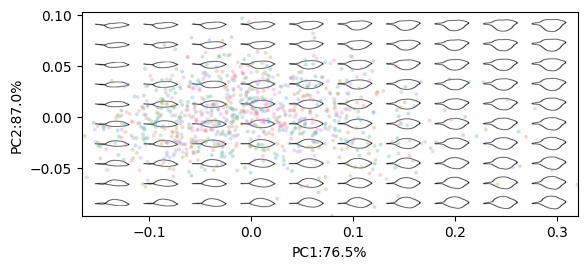

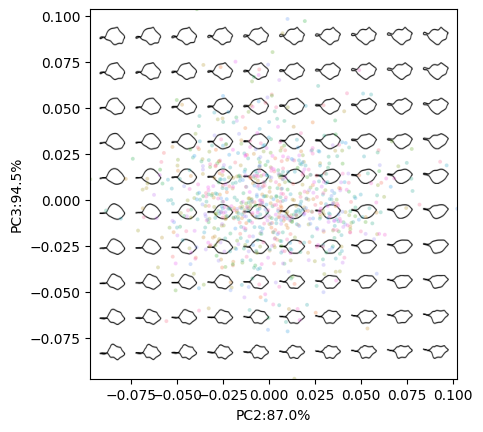

In [ ]:
for z in range(2):

    n = 10
    grid_x = np.linspace(np.min(principalComponents[:,z]), np.max(principalComponents[:,z]),n)
    grid_y = np.linspace(np.min(principalComponents[:,z+1]), np.max(principalComponents[:,z+1]),n)

    k=1

    for i, yi in enumerate(grid_y[::-1]):
        for j, xi in enumerate(grid_x):
            plt.subplot(n,n,k)
            plt.gca().set_aspect('equal')
            plt.axis("off")
            value = get_coeff_from_pca_coordinates(pca, xi, yi, z)
            contours = pyefd.reconstruct_contour(value.reshape(EFD_HARMONICS, 4))
            plt.plot(contours[:,0],contours[:,1],color="black",linewidth=1)
            plt.fill_between(contours[:,0],contours[:,1],color="white")
            k +=1
    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    xmin, xmax = np.min(grid_x), np.max(grid_x)
    ymin, ymax = np.min(grid_y), np.max(grid_y)
    img = mpimg.imread(buf)
    plt.imshow(img, extent=[xmin,xmax,ymin,ymax])
    plt.gca().set_aspect('equal')
    sns.scatterplot(data=pca_df, x=f"PC{z+1}", y=f"PC{z+2}",alpha=0.3, s=8, hue="apple_id",legend=False)
    plt.xlabel(f"PC{z+1}:{explained[z]}%")
    plt.ylabel(f"PC{z+2}:{explained[z+1]}%")
    plt.show()

また、PCA plotだけでなく、第N主成分ごとの形への影響をもう少し詳しくみてみましょう。第N主成分の値が0、大きな負の値、大きな正の値のときのそれぞれの輪郭を黒、青、赤で描画しています。

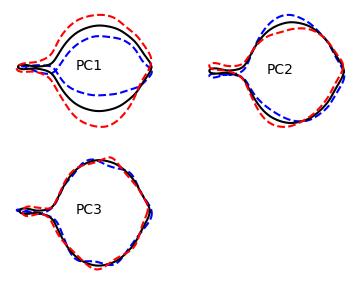

In [ ]:
def pc2efv(pca, n, unit):
    vec = [0] * len(pca.explained_variance_)
    vec[n]= unit * np.sqrt(pca.explained_variance_[n])
    vec = np.dot(vec, pca.components_.T) + pca.mean_
    vvec = np.array([1,0,0])
    return np.concatenate([vvec,vec])
def pc2efm(res,n,unit):
    efm = pc2efv(res, n, -1*unit)
    efm = np.c_[efm,pc2efv(res,n,0)]
    efm = np.c_[efm,pc2efv(res,n,unit)]
    return efm.T

plt.figure(figsize=(4,3))

colors = ["blue", "black", "red"]
styles = ["dashed", "solid", "dashed"]
for i in range(1,4):
    plt.subplot(2,2,i)
    plt.text(-0.2,-0.01,"PC"+str(i))
    plt.axis("off")
    n = i -1
    unit = 2
    efms = pc2efm(pca, n, unit)

    for color, style, efm in zip(colors, styles, efms):
        contours = pyefd.reconstruct_contour(efm.reshape(15,4))  #pyefd function
        plt.plot(contours[:,0],contours[:,1],linestyle=style,color=color)

    plt.tight_layout()

上の結果から、各主成分がそれぞれ以下のような形状に関与していることを示唆します。

PC1：葉身の幅
PC2:葉の非対称性
PC3:輪郭のいびつさ
PC1が最も大きい・小さい品種を特定し、画像として表示してみましょう。

In [ ]:
pc1_min = pca_df[pca_df["PC1"] == pca_df["PC1"].min()]["apple_id"].values
print(pc1_min)

pc1_max = pca_df[pca_df["PC1"] == pca_df["PC1"].max()]["apple_id"].values
print(pc1_max)

['265']
['1213']


PC1が最も小さい・大きい品種はそれぞれapple_idが265と1213であることがわかりました。ノートブック冒頭で読み込んだアノテーションデータフレームdfからファイル名を特定し、表示します。

apple_id: 265


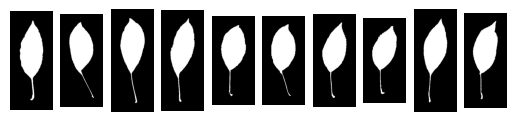

apple_id: 1213


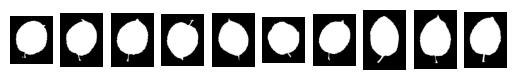

In [ ]:
for a_id in [265,1213]:
    _df = annotation_df[annotation_df["apple_id"]==a_id]
    n = len(_df)
    print(f"apple_id: {a_id}")
    for i,(idx, row) in enumerate(_df.iterrows()):
        plt.subplot(1,n,i+1)
        file = row["image_name"]
        path = os.path.join(IMAGE_DIR, file +".jpg")
        image = cv2.imread(path)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

このように、輪郭形状を表現できる楕円フーリエ記述子をノートブック前半の手動特徴量設計と組み合わせれば、柔軟な表現型解析が可能となるでしょう。